# Recoloring CNN

## Import

In [1]:
import torch, os
import matplotlib.pyplot as plt
import torchvision.transforms as t
from PIL import Image, ImageOps
from pathlib import Path

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import torchvision.models as models

!pip install kornia
from turtle import color
from itertools import chain
from kornia.color import rgb_to_lab, lab_to_rgb
import numpy as np

## Data preprocessing

In [2]:
# Helper function to add black borders so that full image can be used 
# taken from https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
def resize_with_padding(img, expected_size): 
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [3]:
class Data(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
        # List all images in folder and count them
        self.all_imgs = os.listdir(main_dir)
    
    def __len__(self):
        # Return the previously computed number of images
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])

        # Use PIL for image loading
        img = Image.open(img_loc).convert("RGB")
        
        # Apply transformations
        img = resize_with_padding(img, (256, 256))
        image = self.transform(img)

        # Turn RBG -> LAB
        img_lab = rgb_to_lab(image)
        
        # Extract l and ab channels into sepparate tensors
        img_ab = img_lab[1:3,:,:]
        img_ab = np.asarray(img_ab)
        img_ab = img_ab / 128
        img_ab = torch.from_numpy(img_ab).float()
        img_l = img_lab[0:1,:,:]
        img_l = np.asarray(img_l)
        img_l = img_l / 100
        img_l = torch.from_numpy(img_l).float()
        
        img_orig = image

        return img_orig, img_l, img_ab

In [4]:
# Create dataloaders 
gen_path = Path.cwd() / "gen"

colors = ['blue', 'yellow', 'green', 'by', 'bgy']


c_paths = [Path.cwd()/ f"c_{color}" for color in colors]
c_val_path = Path.cwd() / f"c_val"

transform = Compose([t.ToTensor()])

b_size = 4

gen_dataset = Data(gen_path, transform)
gen_dataloader = DataLoader(gen_dataset, batch_size=b_size, shuffle=True)

c_dataloaders = [DataLoader(Data(path, transform), batch_size=b_size, shuffle=True) for path in c_paths]
test_dataset = Data(c_val_path, transform)           
c_val_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True) 

In [5]:
def plot_images(org_input, l_input, ab_input, img_size = 256): 
    '''Show original, grayscale and combined image'''
    
    # Genrate ab for grayscale plot
    bw_ab = torch.zeros((2,img_size,img_size))

    # Combine channels
    ab_input = np.asarray(ab_input)
    ab_input = ab_input *128
    ab_input = torch.from_numpy(ab_input).float()
    l_input = np.asarray(l_input)
    l_input = l_input * 100
    l_input = torch.from_numpy(l_input).float()
    color_image = torch.cat((l_input, ab_input), 0)
    bw_image = torch.cat((l_input, bw_ab), 0)
    
    # Lab -> RBG for plotting
    color_img = lab_to_rgb(color_image)
    bw_img = lab_to_rgb(bw_image)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    
    print("Orignal image, Black and white, Our prediction")
    axes[0].imshow(org_input.permute(1, 2, 0), cmap='gray') # orignal picture
    
    axes[1].imshow(bw_img.permute(1, 2, 0), cmap='gray') # bw
    
    axes[2].imshow(color_img.permute(1, 2, 0), cmap='gray') # combined
    plt.show()

Orignal image, Black and white, Our prediction


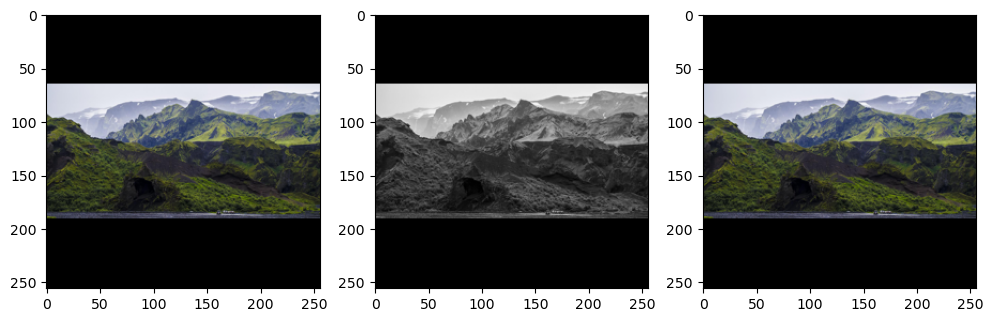

torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([2, 256, 256])


In [6]:
# Example usage
o, l, ab = test_dataset[4]
plot_images(o, l, ab)
print(o.shape, l.shape, ab.shape)

In [7]:
# Model taken from https://github.com/erykml/video_games_colorization
class ResnetColorizer(nn.Module):
    def __init__(self):
        super(ResnetColorizer, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        
        ## ResNet
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        
        self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')

        ## Upsampling and colorization
        self.upsample = nn.Sequential(     
            nn.Conv2d(in_channels=MIDLEVEL_FEATURE_SIZE,
                      out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            self.upsampling,
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            self.upsampling,
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(in_channels=32, out_channels=2,
                      kernel_size=(3, 3), stride=1, padding=1),
            self.upsampling
        )

    def forward(self, input):

        # ResNet - feature extraction
        midlevel_features = self.midlevel_resnet(input)

        # Upsampling and colorization
        output = self.upsample(midlevel_features)
        return output

Orignal image, Black and white, Our prediction


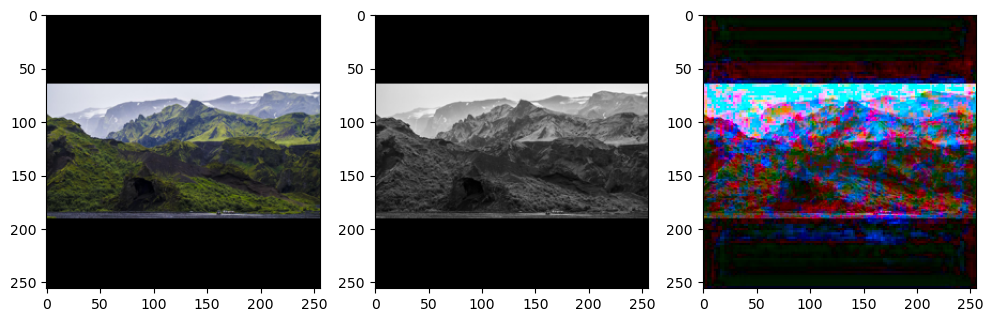

In [8]:
# Test a forward pass though the network
model = ResnetColorizer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

o, l, ab = test_dataset[4]
l_batch = torch.unsqueeze(l, 0)
ab_res = model.forward(l_batch).detach()
ab_res = torch.squeeze(ab_res, dim = 0)

plot_images(o, l, ab_res)

# Training

In [9]:
# Helper function to plot losses during training
def plot_metrics(fig, ax, ns, train_losses, val_losses, title, if_val):
    ax.clear()
    ax.plot(ns, train_losses)
    if if_val:
        ax.plot(ns, val_losses)
        ax.legend(['Train','Validation'])
    
    ax.set_title(f'Loss for {title} model')
    ax.set_xlabel('Number of batches')
    ax.grid()
    
    fig.canvas.draw()

In [10]:
# Setup the figure for plotting progress during training
def train(batches, model, loss_fn, optimizer, dataloader, val_dataloader, title, if_val):
    %matplotlib notebook 

    fig, ax = plt.subplots(ncols=1, figsize=(10,4))
    plt.ion()
    plot_interval = 50
    batch_idxs = []
    batch  = 0

    losses, val_losses = [], []
    train_data = {'losses': []}
    val_data = {'losses': []}

    model.train()
    while(batch < batches):
        for o, b_l, b_ab in dataloader: #train_dataloader:
            optimizer.zero_grad()
            pred_ab = model.forward(b_l)

            loss = loss_fn(pred_ab, b_ab)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            batch += 1

            if batch % plot_interval == 0:
                if (batch != plot_interval): # First value doen't make sense
                    train_data['losses'].append((sum(losses)/len(losses)))
                    if if_val:
                        val_data['losses'].append(val(model, loss_fn, val_dataloader))  
                    batch_idxs.append(batch) 

                plot_metrics(fig, ax, batch_idxs, train_data['losses'], val_data['losses'], title, if_val) 
                
            if(batch > batches):
                break
    
    return model

def val(model, loss_fn, val_dataloader):
    # Compute predictions in the validation set (with adagrad deactivated)
    with torch.no_grad():
        val_losses = []
        
        for vo, vb_l, vb_ab in val_dataloader: 
            val_pred = model.forward(vb_l)
            val_loss = loss_fn(val_pred, vb_ab)
            val_losses.append(val_loss.item())

    return sum(val_losses)/len(val_losses)
            

<IPython.core.display.Javascript object>


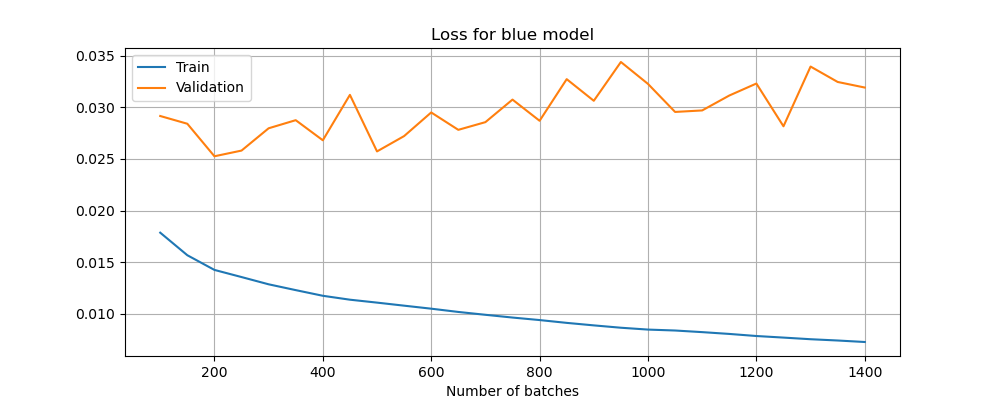

<IPython.core.display.Javascript object>


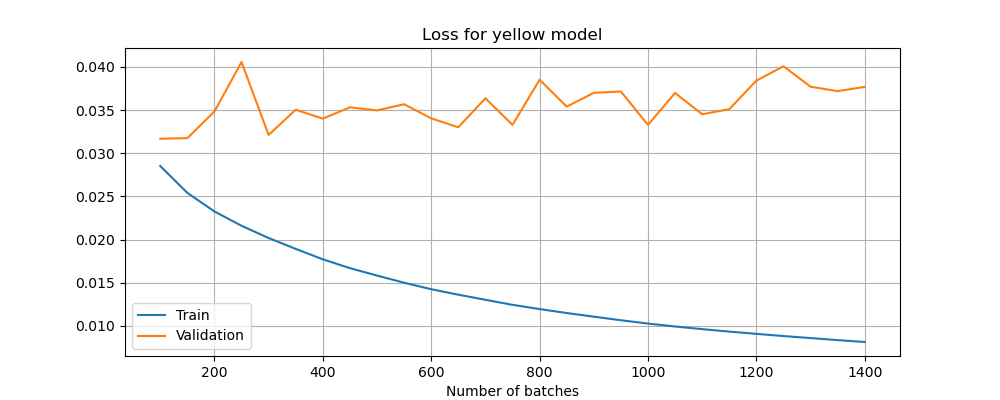

<IPython.core.display.Javascript object>


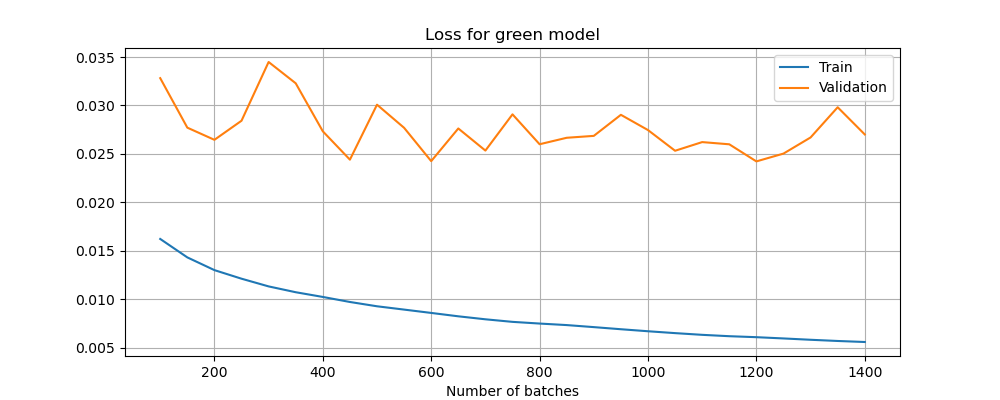

In [11]:
# If you want live plots in your notebook
%matplotlib notebook 
nmb_of_batches = 1400

c_models = []
# Train blue, yellow, green models
for idx in [0,1,2]:
    model = ResnetColorizer() 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
    tmp = train(nmb_of_batches, model, loss_fn, optimizer, c_dataloaders[idx], c_val_dataloader, colors[idx], True)
    c_models.append(tmp)

<IPython.core.display.Javascript object>


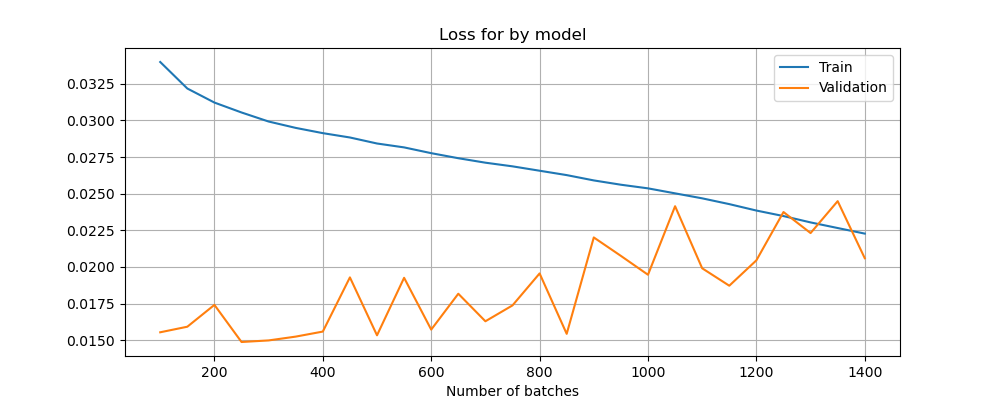

<IPython.core.display.Javascript object>


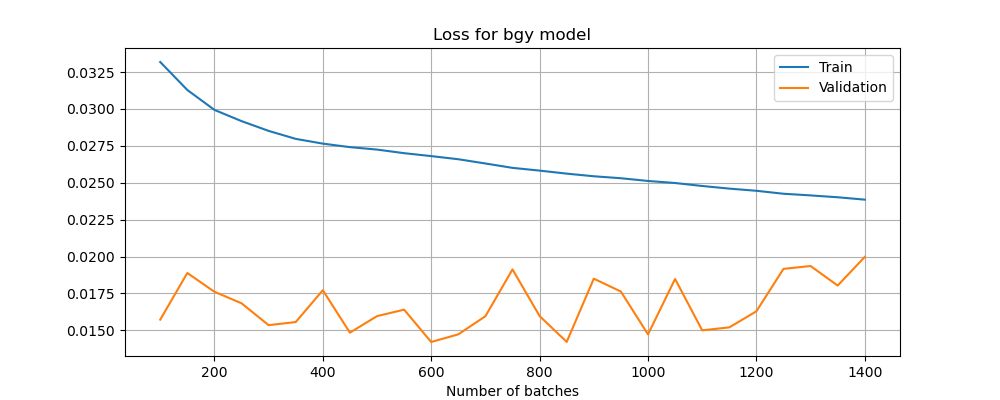

In [12]:
# Train blue/yellow and blue/green/yellow models
for idx in [3,4]:
    model = ResnetColorizer() 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
    tmp = train(nmb_of_batches, model, loss_fn, optimizer, c_dataloaders[idx], c_val_dataloader, colors[idx],  True)
    c_models.append(tmp)

<IPython.core.display.Javascript object>


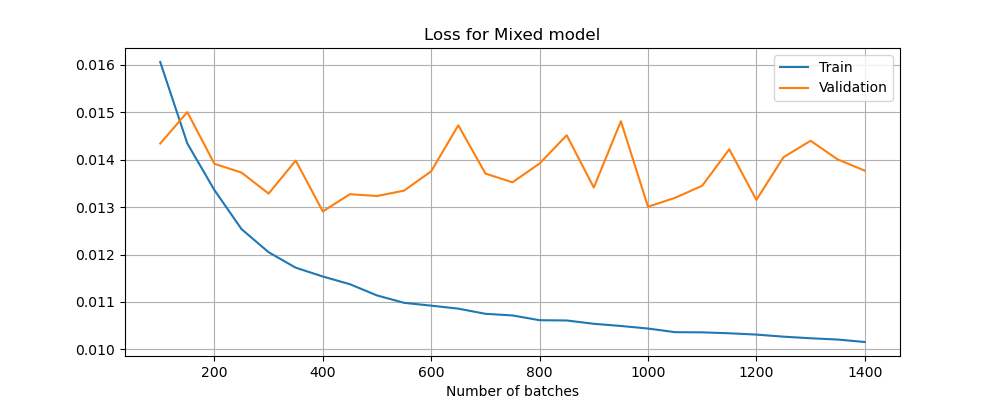

In [13]:
# Train general model 
model = ResnetColorizer() 
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
tmp = train(nmb_of_batches, model, loss_fn, optimizer, gen_dataloader, c_val_dataloader, 'Mixed',  True)
c_models.append(tmp)

# Evaluation

In [14]:
%matplotlib inline

# Nice images:  1, 9, 12, 14!
# counterex : 5, 8, 13
image_idx = 1 # Index from validation dataset

In [15]:
def plot_images_ab(l_input, ab_input, img_size = 256):
    '''Show a, b image from ab channels'''
    
    filler = torch.zeros((1,img_size,img_size))
    
    l = np.asarray(l_input)
    l = l * 100
    l = torch.from_numpy(l).float()
    
    ab = np.asarray(ab_input)
    ab = ab * 128
    
    a = ab[0:1,:,:]
    b = ab[0:1,:,:]
    a = torch.from_numpy(a).float()
    b = torch.from_numpy(b).float()
    
    
    a_img = torch.cat((l, a), 0)
    a_img = torch.cat((a_img, filler), 0)
    
    b_img = torch.cat((l, filler), 0)
    b_img = torch.cat((b_img, b), 0)

    ab = torch.from_numpy(ab).float()
    ab_img = torch.cat((l, ab), 0)
    
    # Lab -> RBG for plotting
    a_img = lab_to_rgb(a_img)
    b_img = lab_to_rgb(b_img)
    ab_img = lab_to_rgb(ab_img)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    print("la, lb, lab")
    axes[0].imshow(a_img.permute(1, 2, 0), cmap='gray') # a-channel
    
    axes[1].imshow(b_img.permute(1, 2, 0), cmap='gray') # b-channel
    
    axes[2].imshow(ab_img.permute(1, 2, 0), cmap='gray') # ab-channel


Orignal image, Black and white, Our prediction


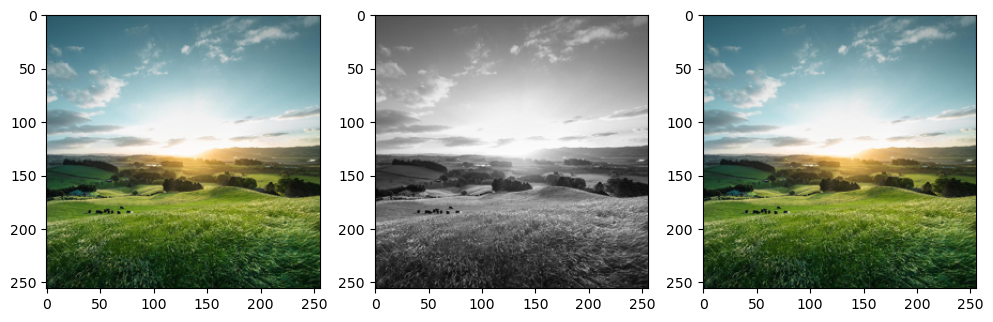

In [16]:
o, l, ab = test_dataset[image_idx]
plot_images(o, l, ab)

la, lb, lab


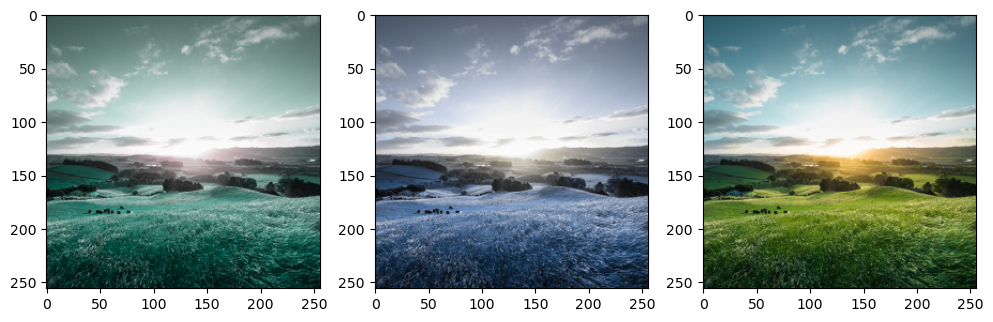

In [17]:
plot_images_ab(l, ab)

Random image tested for full model
Orignal image, Black and white, Our prediction


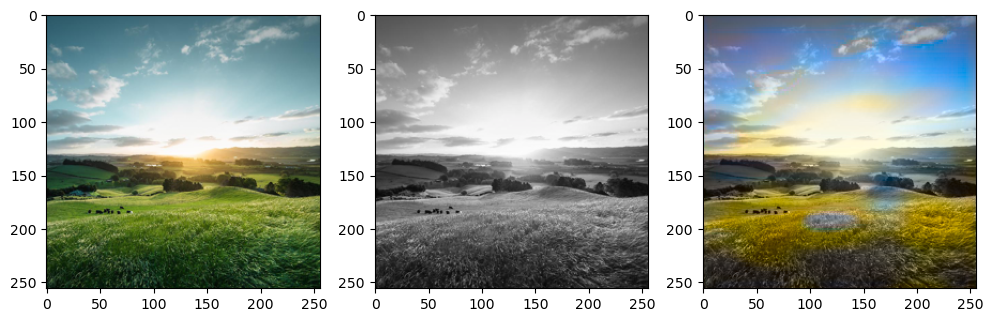

In [18]:
# Plot general model
with torch.no_grad():
    o, l, ab = test_dataset[image_idx]
    l_batch = torch.unsqueeze(l, 0)
    print(f'Random image tested for full model')
    ab_res = c_models[idx].forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_images(o, l, ab_res)
    #plot_images_ab(l, ab)

Random image tested for blue model
la, lb, lab
Random image tested for yellow model
la, lb, lab
Random image tested for green model
la, lb, lab


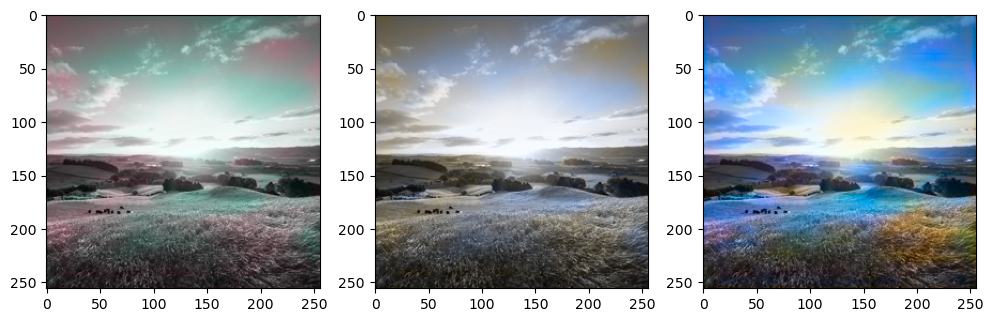

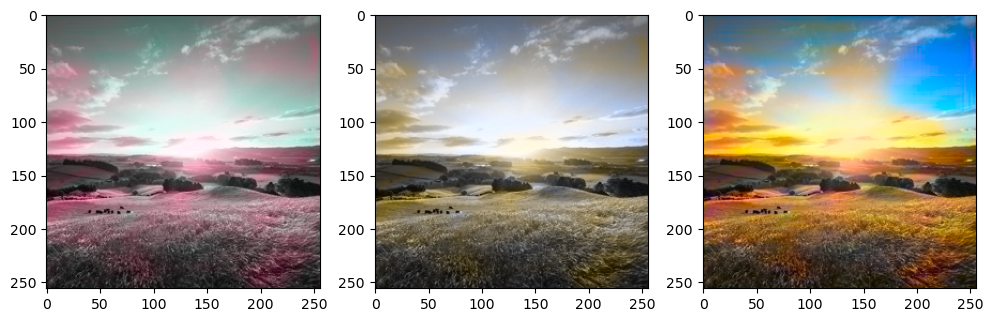

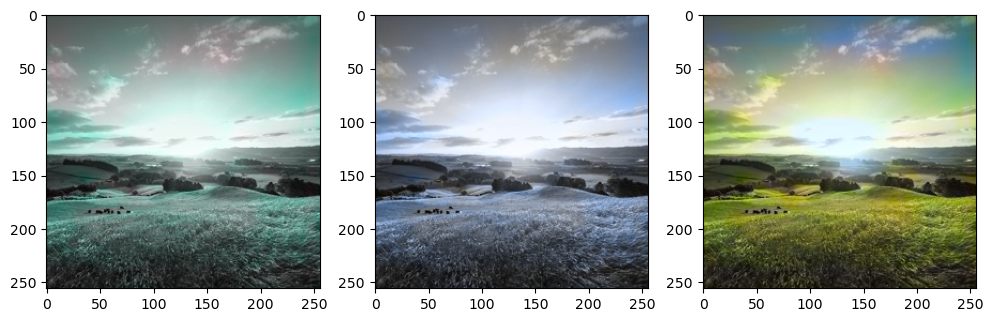

In [19]:
# Plot output of single color models
with torch.no_grad():
    o, l, ab = test_dataset[image_idx]
    l_batch = torch.unsqueeze(l, 0)
    for idx in [0,1,2]:
        print(f'Random image tested for {colors[idx]} model')
        ab_res = c_models[idx].forward(l_batch)
        ab_res = ab_res.cpu()
        ab_res = torch.squeeze(ab_res, dim = 0)
        #plot_images(o, l, ab_res)
        plot_images_ab(l, ab_res)


Random image tested for by model
la, lb, lab
Random image tested for bgy model
la, lb, lab


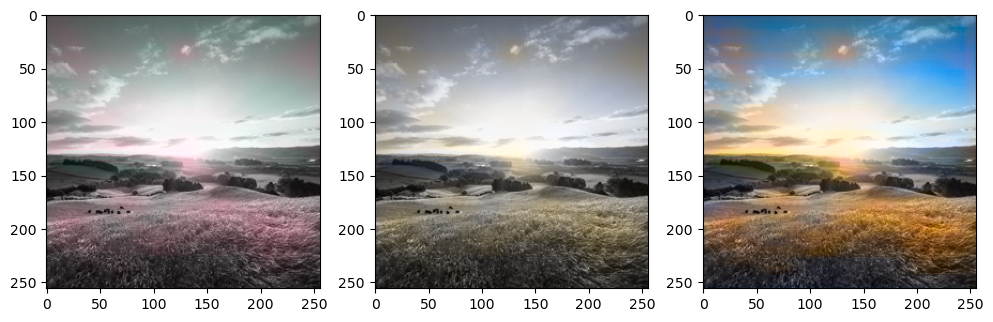

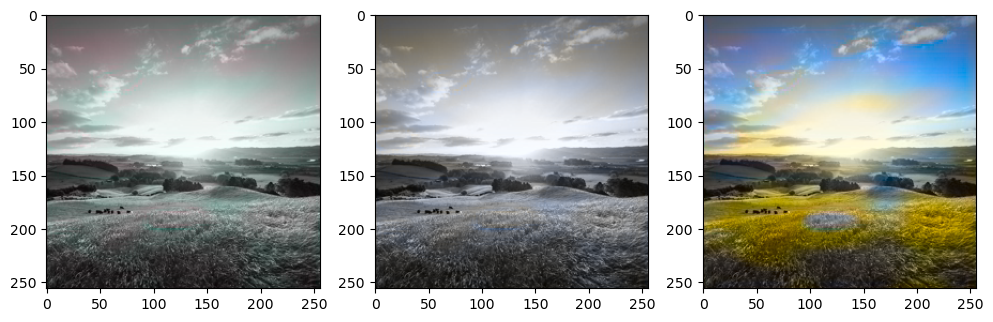

In [20]:
# Plot output of multicolor models
with torch.no_grad():
    o, l, ab = test_dataset[image_idx]
    l_batch = torch.unsqueeze(l, 0)
    for idx in [3,4]:
        print(f'Random image tested for {colors[idx]} model')
        ab_res = c_models[idx].forward(l_batch)
        ab_res = ab_res.cpu()
        ab_res = torch.squeeze(ab_res, dim = 0)
        #plot_images(o, l, ab_res)
        plot_images_ab(l, ab_res)

Random image tested for avg of blue and yellow model
la, lb, lab
Random image tested for avg of blue, green and yellow model
la, lb, lab


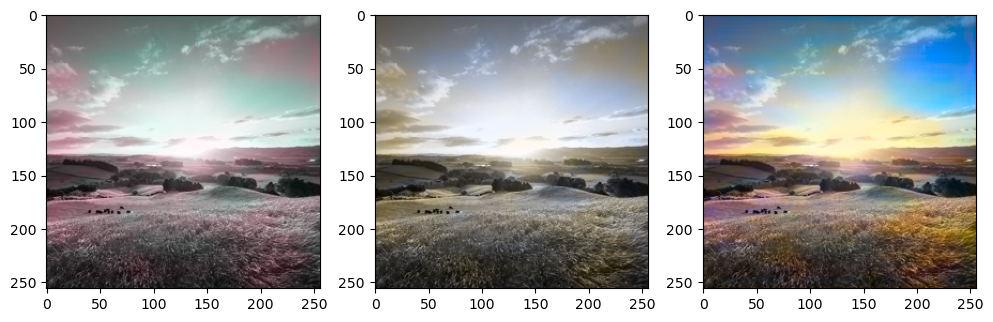

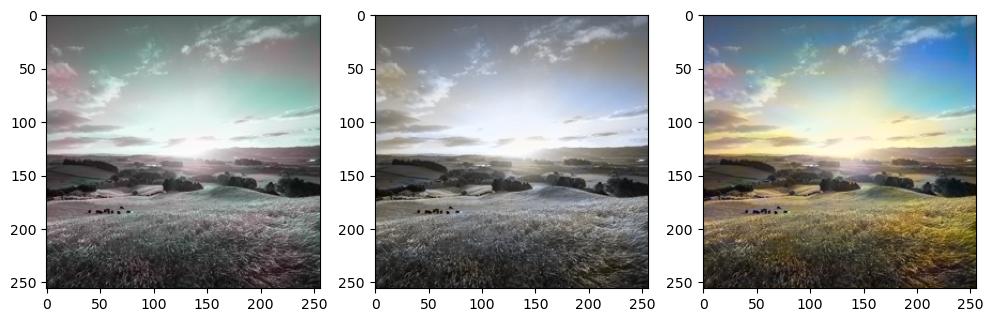

In [21]:
# Plot result when averaging models 
with torch.no_grad():
    o, l, ab = test_dataset[image_idx]
    l_batch = torch.unsqueeze(l, 0)
    b_ab_res = c_models[0].forward(l_batch)
    y_ab_res = c_models[1].forward(l_batch)
    g_ab_res = c_models[2].forward(l_batch)
    b = b_ab_res * 0.5
    y = y_ab_res * 0.5
    by = b.add(y)
    b = b_ab_res * 0.33
    y = y_ab_res * 0.33
    g = g_ab_res * 0.33
    bg = b.add(g)
    bgy = bg.add(y)
    by = by.cpu()
    bgy = bgy.cpu()
    by = torch.squeeze(by, dim = 0)
    bgy = torch.squeeze(bgy, dim = 0)
    print(f'Random image tested for avg of blue and yellow model')
    #plot_images(o, l, by)
    plot_images_ab(l, by)
    print(f'Random image tested for avg of blue, green and yellow model')
    #plot_images(o, l, bgy)
    plot_images_ab(l, bgy)


### Loss comparison

In [22]:
print('Average loss for all models on c_val')
for idx in range(len(colors)):
    avg_val_loss = val(c_models[idx], loss_fn, c_val_dataloader)
    print(f'{colors[idx]}: \t{avg_val_loss}')

avg_val_loss = val(model, loss_fn, c_val_dataloader)
print(f'Gen: \t{avg_val_loss}')

Average loss for all models on c_val
blue: 	0.030293855699710548
yellow: 	0.03740407479926944
green: 	0.025002466281875968
by: 	0.01964279799722135
bgy: 	0.01933611580170691
Gen: 	0.013330724847037345


In [23]:
with torch.no_grad():
    by_comb_losses = []
    bgy_comb_losses = []

    for o, l, ab in c_val_dataloader: 
        b_pred = c_models[0].forward(l)
        y_pred = c_models[1].forward(l)
        g_pred = c_models[2].forward(l)
        
        b = b_pred * 0.5
        y = y_pred * 0.5
        by = b.add(y)
        
        b = b_pred * 0.33
        y = y_pred * 0.33
        g = g_pred * 0.33
        bg = b.add(g)
        bgy = bg.add(y)
        
        by_comb_loss = loss_fn(by, ab)
        by_comb_losses.append(by_comb_loss.item())
        
        bgy_comb_loss = loss_fn(bgy, ab)
        bgy_comb_losses.append(bgy_comb_loss.item())

print(f'Comb by: \t{sum(by_comb_losses)/len(by_comb_losses)}')
print(f'Comb bgy: \t{sum(bgy_comb_losses)/len(bgy_comb_losses)}')

Comb by: 	0.016188196139410138
Comb bgy: 	0.014246896957047284
